In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import warnings; warnings.simplefilter('ignore')
import fitsio
from astropy.table import Table

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
from main_def import get_sweep_patch, cut, cut_sweeps, get_random_patch, get_area, flux_to_mag
from geometric_def import query_catalog_mask, LSLGA_fit, LSLGA_veto, circular_mask_radii_func#, get_GM_stats, get_PM_stats, sky_PM
#from photometric_def import get_photo_stats, plot_venn3, flow_1, flow_2

#import desitarget
#from desitarget.cuts import unextinct_fluxes

import seaborn as sns
sns.set()


# params ini

In [2]:
#Starting up params...
rlimit = 21
N = 3
dr = 'dr8-south'
#define the square/rectangle patch of the sky in format [RAmin, RAmax, DECmin, DECmax]
#main_patch = [195, 200, 5, 10]
main_patch = [160, 230, -2, 18]
#Main label
mainLab = '%s_%s_%s_%s' %(dr, '_'.join(str(i) for i in main_patch), 
                          str(rlimit), str(N))
    
mask_list = {
    #of the form: mask-Name: [applied or not, value(s) if any]
    #Geometrical (GEO) Cuts
    'BS_':[True, None, 'GM', 'Bright Stars', 'Circular (TYCHO2)'],
    'MS_':[False, None, 'GM', 'Medium Stars', 'Circular (GAIA DR2)'],
    'GC_':[False, None, 'GM', 'Globular Clusters', 'Circular (Unknown)'],
    'LG_':[False, None, 'GM', 'Large Galaxies', 'Elliptical (LSLGA)'],
    'allmask_':[False, 0, 'PM', 'ALLMASK', 'ALLMASK_{i} = 0, i=G,R and Z'], 
    'nobs_':[True, 1, 'PM', 'NOBS', 'NOBS_{i} > 0, i=G,R and Z'], 
    #Photometric (PHOT) Cuts
    'SG_':[True, 'gaia', 'PHOT', 'Galaxies with Gaia', '(G-rr > 0.6) or (G=0)'], #others: NoPSF 
    'FMC_':[False, 'v2', 'PHOT', None, ['rfib < 4.1 + r & r < 17.1', 'rfib < 21.2 & 17.7 < r < 18.3', 'rfib < 2.9 + r & r > 18.3']], #others: v1 (first version of FMC)
    'CC_':[True, [-1, 4], 'PHOT', None, ['-1 < g-r < 4', '-1 < r-z < 4']], 
    'QC_FM_':[True, 0.4, 'PHOTQC', 'FRACMASKED (FM)', 'fracmasked_{i}<0.4, i=G,R and Z'], 
    'QC_FI_':[True, 0.3, 'PHOTQC', 'FRACIN (FI)', 'fracin_{i}>0.3, i=G,R and Z'], 
    'QC_FF_':[True, 5.0, 'PHOTQC', 'FRACFLUX (FF)', 'fracflux_{i}<5, i=G,R and Z'], 
    'QC_IVAR_':[True, 0., 'PHOTQC', 'FLUXIVAR', 'flux_ivar_{i}>0, i=G,R and Z']
}        
    
#Cuts label
cutsLab = ''.join(str(i[0]*1) for i in list(mask_list.values()))

#directory name
ramin, ramax, decmin, decmax = main_patch[0], main_patch[1], main_patch[2], main_patch[3]
dir_name = '%s_%s_%s_%s_%s_rmag_%s_N_%s' %(dr, str(ramin), str(ramax), str(decmin), 
                                                 str(decmax), str(rlimit), str(N))
#Subdir name
subdir = '_'.join([mainLab, cutsLab])

print('dir Name: %s' %(dir_name))
print('subdir Name: %s' %(subdir))


dir Name: dr8-south_160_230_-2_18_rmag_21_N_3
subdir Name: dr8-south_160_230_-2_18_21_3_1000011011111


# Get master catalogue from SWEEPS

In [3]:
dir_ = os.path.isdir(dir_name)

if dir_:
    print('The directory with %i < RA < %i, %i < DEC < %i, rmag limit=%2.2g and N=%i already exist...' 
          %(ramin, ramax, decmin, decmax, rlimit, N))
else:
    os.system('mkdir %s' %(dir_name))
    
subdir_ = os.path.isdir(dir_name+'/'+subdir)

if subdir_:
    print('The subdir %s/ already exist...' %(subdir))
else:
    os.system('mkdir %s' %(dir_name+'/'+subdir))

#get subsample catalogue
df = get_sweep_patch(patch=main_patch, rlimit=rlimit, dr=dr)

#give the right permissions to share the subsample catalogue
#!chmod 777 *.npy

The directory with 160 < RA < 230, -2 < DEC < 18, rmag limit=21 and N=3 already exist...
The subdir dr8-south_160_230_-2_18_21_3_1000011011111/ already exist...
sweep file already exist at:/global/project/projectdirs/desi/users/qmxp55/BGS_SV/dr8-south_sweep_160_230_-2_18_rmag_21.npy
Total run time: 0.000518 sec
Area of 160 < RA < 230 & -2 < DEC < 18: 1379 deg^2
Weight of dr8-south_sweep_160_230_-2_18_rmag_21.npy catalogue: 5.13 GB


# Get the RANDOMS from DESITARGET

In [4]:
df_ran = get_random_patch(patch=main_patch, N=N, sweepsize=len(df), dr=dr)

RANDOM file already exist at:/global/project/projectdirs/desi/users/qmxp55/BGS_SV/dr8-south_random_160_230_-2_18_N_3.npy
Total run time: 0.002524 sec
Area of 160 < RA < 230 & -2 < DEC < 18: 1379 deg^2
Weight of dr8-south_random_160_230_-2_18_N_3.npy catalogue: 473.48 MB


# prepare the BGS SV data

In [5]:
rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
rfibmag = flux_to_mag(df['FIBERFLUX_R']/df['MW_TRANSMISSION_R'])
morpho = df['TYPE']

#defining the BGS SV bits
bright = rmag < 19.5
faint = (rmag >= 19.5) & (rmag < 20.1)
faint_ext = (rmag >= 20.1) & (rmag < 20.5)
fmc = (rmag >= 20.1) & (rfibmag < 21.0511)

A = get_area(patch=main_patch, get_val=True)

nomask = np.zeros(len(df), dtype='?')
nomask_ran = np.zeros(len(df_ran), dtype='?')

Area of 160 < RA < 230 & -2 < DEC < 18: 1379 deg^2


## Apply the geometric cuts for BGS SV in catalogue and RANDOMS

In [6]:
def GetGeoCuts():
    
    #GEO cuts CATALOGUE
    BS = (np.uint64(df['MASKBITS']) & np.uint64(2**1))!=0
    MS = (np.uint64(df['MASKBITS']) & np.uint64(2**11))!=0
    GC = (np.uint64(df['MASKBITS']) & np.uint64(2**13))!=0
    LG = ((np.uint64(df['MASKBITS']) & np.uint64(2**12))!=0) & (df['REF_CAT'] != 'L2') #include the LSLGA galaxies removed by LG bit...
    allmask = ((df['MASKBITS'] & 2**6) != 0) | ((df['MASKBITS'] & 2**5) != 0) | ((df['MASKBITS'] & 2**7) != 0)
    nobs = (df['NOBS_G'] < mask_list['nobs_'][1]) | (df['NOBS_R'] < mask_list['nobs_'][1]) | (df['NOBS_Z'] < mask_list['nobs_'][1])

    #GEO cuts RANDOMS
    BS_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**1))!=0
    MS_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**11))!=0
    GC_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**13))!=0
    LG_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**12))!=0
    allmask_ran = ((df_ran['MASKBITS'] & 2**6) != 0) | ((df_ran['MASKBITS'] & 2**5) != 0) | ((df_ran['MASKBITS'] & 2**7) != 0)
    nobs_ran = (df_ran['NOBS_G'] < mask_list['nobs_'][1]) | (df_ran['NOBS_R'] < mask_list['nobs_'][1]) | (df_ran['NOBS_Z'] < mask_list['nobs_'][1])

    #GeoCut_ = [BS, MS, GC, LG, allmask, nobs]
    
    GeoCut = {'BS':BS,
              'MS':MS,
              'GC':GC,
              'LG':LG,
              'allmask':allmask,
              'nobs':nobs
             }
    
    GeoCut_ran = {'BS_ran':BS_ran,
              'MS_ran':MS_ran,
              'GC_ran':GC_ran,
              'LG_ran':LG_ran,
              'allmask_ran':allmask_ran,
              'nobs_ran':nobs_ran
             }
    
    #Replace with non-mask arrays (False bool-array) if cut is set False.
    for key in GeoCut.keys():
        if not mask_list[key + '_'][0]:
            #print(key+'_before', np.sum(GeoCut[key]))
            GeoCut[key] = nomask.copy()
            GeoCut_ran[key + '_ran'] = nomask_ran.copy()
            #print(key+'_after', np.sum(GeoCut[key]))
    
    return GeoCut, GeoCut_ran

GeoCut, GeoCut_ran = GetGeoCuts()

## Apply the photometric cuts for BGS SV in catalogue only

In [7]:
def GetPhotCuts():
    
    def get_stars_sv(gaiagmag, fluxr, morpho):
    
        Grr = gaiagmag - 22.5 + 2.5*np.log10(fluxr)
        GAIA_STAR = np.ones_like(gaiagmag, dtype='?')
        GAIA_STAR &= (Grr  <  0.6) & (gaiagmag != 0) & (morpho == 'PSF ')
    
        return GAIA_STAR

    def get_galaxies_sv(gaiagmag, fluxr, morpho):
    
        Grr = gaiagmag - 22.5 + 2.5*np.log10(fluxr)
        GAIA_GAL = np.ones_like(gaiagmag, dtype='?')
        GAIA_GAL &= (Grr  >  0.6) | (gaiagmag == 0) | (morpho != 'PSF ')
    
        return GAIA_GAL
    
    #Photometric cuts CATALOGUE
    STARS = get_stars_sv(gaiagmag=df['GAIA_PHOT_G_MEAN_MAG'], fluxr=df['FLUX_R'], morpho=morpho)
    GAL = get_galaxies_sv(gaiagmag=df['GAIA_PHOT_G_MEAN_MAG'], fluxr=df['FLUX_R'], morpho=morpho)
    
    FMCV1 = rfibmag < 2.9 + rmag
    FMCV2 = nomask.copy()
    FMCV2 |= ((rfibmag < (2.9 + 1.2) + rmag) & (rmag < 17.1))
    FMCV2 |= ((rfibmag < 21.2) & (rmag < 18.3) & (rmag > 17.1))
    FMCV2 |= ((rfibmag < 2.9 + rmag) & (rmag > 18.3))
    FMC = ~nomask.copy()
    if mask_list['FMC_'][1] is 'v1':
        FMC &= FMCV1
    elif mask_list['FMC_'][1] is 'v2':
        FMC &= FMCV2
    else:
        print('Choose either V1 or V2 for FMC...')
    
    CC = ~nomask.copy()
    CC &= ((gmag - rmag) > mask_list['CC_'][1][0]) 
    CC &= ((gmag - rmag) < mask_list['CC_'][1][1]) 
    CC &= ((rmag - zmag) > mask_list['CC_'][1][0]) 
    CC &= ((rmag - zmag) < mask_list['CC_'][1][1])

    QC_FM = ~nomask.copy()
    QC_FM &= (df['FRACMASKED_R'] < mask_list['QC_FM_'][1]) 
    QC_FM &= (df['FRACMASKED_G'] < mask_list['QC_FM_'][1]) 
    QC_FM &= (df['FRACMASKED_Z'] < mask_list['QC_FM_'][1])
    
    QC_FI = ~nomask.copy()
    QC_FI &= (df['FRACIN_R'] > mask_list['QC_FI_'][1]) 
    QC_FI &= (df['FRACIN_G'] > mask_list['QC_FI_'][1]) 
    QC_FI &= (df['FRACIN_Z'] > mask_list['QC_FI_'][1])
    
    QC_FF = ~nomask.copy()
    QC_FF &= (df['FRACFLUX_R'] < mask_list['QC_FF_'][1]) 
    QC_FF &= (df['FRACFLUX_G'] < mask_list['QC_FF_'][1]) 
    QC_FF &= (df['FRACFLUX_Z'] < mask_list['QC_FF_'][1])
    
    QC_IVAR = ~nomask.copy()
    QC_IVAR &= (df['FLUX_IVAR_R'] > mask_list['QC_IVAR_'][1]) 
    QC_IVAR &= (df['FLUX_IVAR_G'] > mask_list['QC_IVAR_'][1]) 
    QC_IVAR &= (df['FLUX_IVAR_Z'] > mask_list['QC_IVAR_'][1])

    
    PhotCut = {'SG':GAL,
              'FMC':FMC,
              'CC':CC,
              'QC_FM':QC_FM,
              'QC_FI':QC_FI,
              'QC_FF':QC_FF,
              'QC_IVAR':QC_IVAR
             }
    
    #Replace with non-mask arrays (True bool-array) if cut is set False.
    for key in PhotCut.keys():
        if not mask_list[key + '_'][0]:
            #print(key+'_before', np.sum(photCut[key]))
            PhotCut[key] = ~nomask.copy()
            #print(key+'_after', np.sum(photCut[key]))
    
    return PhotCut

PhotCut = GetPhotCuts()

In [8]:
def GetPhotoStats(GeoCutsDict, GeoCutsDict_ran, PhotCutsDict, CurrentMask, 
                 PrevMask, A, bits):
    
    from astropy.table import Table
    GMT_ran = nomask_ran.copy()
    PMT = nomask.copy()
    CMT = nomask.copy()
    
    for i in PrevMask:
        if i in GeoCutsDict.keys():
            GMT_ran |= GeoCutsDict_ran[i+'_ran']
    
    #totmask = np.ones_like(mask, dtype='?')
    Tab = []
    A_G_out = (np.sum(~GMT_ran)/len(GMT_ran))*(A)
    
    PM_lab = []
    for i in PrevMask:
        if i in GeoCutsDict.keys():
            PMT |= GeoCutsDict[i]
            PM_lab.append('~%s' %(i))
        elif i in PhotCutsDict.keys():
            PMT |= ~PhotCutsDict[i]
            PM_lab.append('%s' %(i))
        else:
            print('%s is neither in GeoCuts or PhotCuts...')
    
    for i in CurrentMask:
        CM_lab = '~%s' %(i)
        Tab0 = []
        Tab0.append(CM_lab)
        for key, val in zip(bits.keys(), bits.values()):
            eta_in = np.sum((~PhotCutsDict[i]) & (~PMT) & (val))/(A_G_out)
            Tab0.append(round(eta_in, 2))
        Tab.append(Tab0)
        
        #eta_F_in = np.sum((~PhotCutsDict[i]) & (~PMT) & (F))/(A_G_out)
        #eta_B_in, eta_F_in = round(eta_B_in, 2), round(eta_F_in, 2)
        #Tab.append([CM_lab, eta_B_in, eta_F_in])
        CMT |= ~PhotCutsDict[i]
        
    if len(CurrentMask) > 1:
        CMT_lab_in = '~(%s)' %('&'.join(CurrentMask))
        CMT_lab_out = '(%s)' %('&'.join(CurrentMask))
        Tab0 = []
        Tab0.append(CMT_lab_in)
        for key, val in zip(bits.keys(), bits.values()):
            eta_inT = np.sum((CMT) & (~PMT) & (val))/(A_G_out)
            Tab0.append(round(eta_inT, 2))
        Tab.append(Tab0)
            
        #eta_F_inT = np.sum((CMT) & (~PMT) & (F))/(A_G_out)
        #eta_B_inT, eta_F_inT = round(eta_B_inT, 2), round(eta_F_inT, 2)
        #Tab.append([CMT_lab_in, eta_B_inT, eta_F_inT])
    else:
        CMT_lab_out = '(%s)' %(CurrentMask[0])
        
    Tab0 = []
    Tab0.append(CMT_lab_out)
    for key, val in zip(bits.keys(), bits.values()):
        eta_outT = np.sum((~CMT) & (~PMT) & (val))/(A_G_out) #Corrected for mask area
        Tab0.append(round(eta_outT, 2))
    Tab.append(Tab0)
        
    #eta_F_outT = np.sum((~CMT) & (~PMT) & (F))/(A_G_out) #Corrected for mask area
    #eta_B_outT, eta_F_outT = round(eta_B_outT, 2), round(eta_F_outT, 2)
    #Tab.append([CMT_lab_out, eta_B_outT, eta_F_outT])
    
    Tab = np.transpose(Tab)
    t = Table([Tab[0], Tab[1], Tab[2], Tab[3], Tab[4]], names=('PHOTOMETRY','$\eta_{B}$ [deg$^2$]', 
            '$\eta_{F}$ [deg$^2$]', '$\eta_{Fe}$ [deg$^2$]', '$\eta_{fmc}$ [deg$^2$]'), 
              dtype=('S', 'f8', 'f8', 'f8', 'f8'))
    
    print('Previous Cuts: (%s)' %(' & '.join(PM_lab)))
    print('Current Cuts: %s' %(CMT_lab_out))
        
    return t, A_G_out


In [10]:
def cuts(clist='bgs', geocut=GeoCut, photcut=PhotCut):
    '''
    Extract sources with desired BGS cuts.
    
    Return:: boolean-array:: True are the objects kept and False the objects rejected by the cuts applied.
    '''
    
    mask = np.ones_like(GeoCut[list(GeoCut.keys())[0]], dtype='?')
    if (clist is not 'bgs') & (clist is not 'lowq'):
        for key in clist:
            if key in GeoCut.keys():
                mask &= ~GeoCut[key]
            elif key in PhotCut.keys():
                mask &= PhotCut[key]
            else:
                raise ValueError("%s is not a valid BGS cut..." %(key))
                
    elif clist is 'bgs':
        #print('is BGS....')
        for key in GeoCut.keys():
            mask &= ~GeoCut[key]
        for key in PhotCut.keys():
            mask &= PhotCut[key]
    
    #lowq comprises all galaxies according to our GAIA star-galaxy classification that did not pass our quality control
    elif clist is 'lowq':
        mask = np.zeros_like(GeoCut[list(GeoCut.keys())[0]], dtype='?')
        for key in GeoCut.keys():
            mask |= GeoCut[key]
        for key in PhotCut.keys():
            if key == 'SG':
                continue
            #print(key)
            mask |= ~PhotCut[key]
        mask = (mask) & (PhotCut['SG'])
    
    return mask

# Define the BGS SV bits

In [11]:
bgs_sv = cuts('bgs')
bgs_sv_bits = {'bright':(bgs_sv & bright), 
               'faint':(bgs_sv & faint), 
               'faint_ext':(bgs_sv & faint_ext), 
               'fmc':(bgs_sv & fmc), 
               'lowq':(cuts('lowq') & (rmag < 20.1))
              }

bgs_sv_any = np.zeros_like(df['RA'], dtype='?')
for val in bgs_sv_bits.values():
    bgs_sv_any |= val

# Validating BGS SV targets in DESITARGET

To validate DESITARGET we compare our catalogue with the official DESITARGET catalogue for BGS SV targets.

In [12]:
from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir

In [14]:
#Load sample of resolve DR8 SV target catalogue
hpdirname_sv1 = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/sv/resolve'

# Read targets in an RAmin, RAmax, DECmin, DECmax (degrees) "box".
columns = ['RA', 'DEC', "SV1_DESI_TARGET", "SV1_BGS_TARGET", "TARGETID"]
dt_sv = read_targets_in_box(hpdirname_sv1, main_patch, columns=columns)

print('# rows = %i' %(len(dt_sv)))
print('# cols = %i' %(len(dt_sv.dtype.names)))

# rows = 14296732
# cols = 5


In [15]:
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask

In [61]:
bgs_sv_any_DT = (dt_sv["SV1_DESI_TARGET"] & desi_mask["BGS_ANY"]) != 0
bgs_sv_bits_DT = {'bright':((dt_sv["SV1_BGS_TARGET"] & bgs_mask['BGS_BRIGHT']) != 0), 
                   'faint':((dt_sv["SV1_BGS_TARGET"] & bgs_mask['BGS_FAINT']) != 0), 
                   'faint_ext':((dt_sv["SV1_BGS_TARGET"] & bgs_mask['BGS_FAINT_EXT']) != 0), 
                   'fmc':((dt_sv["SV1_BGS_TARGET"] & bgs_mask['BGS_FIBMAG']) != 0), 
                   'lowq':((dt_sv["SV1_BGS_TARGET"] & bgs_mask['BGS_LOWQ']) != 0)
                  }

In [62]:
print('any', np.sum(bgs_sv_any), np.sum(bgs_sv_any_DT), np.sum(bgs_sv_any) - np.sum(bgs_sv_any_DT))
print('--------------------------')
for key, val, valDT in zip(bgs_sv_bits.keys(), bgs_sv_bits.values(), bgs_sv_bits_DT.values()):
    print(key, np.sum(val), np.sum(valDT), np.sum(val) - np.sum(valDT))

any 3404427 3404433 -6
--------------------------
bright 1193609 1193609 0
faint 1011928 1011928 0
faint_ext 1068114 1068119 -5
fmc 284667 284669 -2
lowq 68068 68068 0


[9248835, 4759834, 5324152, 6190905, 12783289, 11137766, 11137766, 6190905, 5324152, 4759834, 12783289, 9248835]


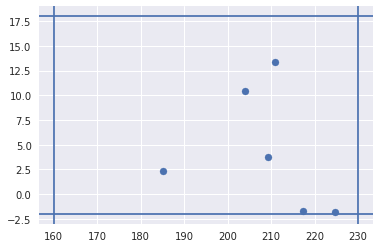

In [66]:
#get the indexes of mismatches targets
RAnot = list(set(dt_sv['RA'][bgs_sv_any_DT]) - set(df['RA'][bgs_sv_any]))
DECnot = list(set(dt_sv['DEC'][bgs_sv_any_DT]) - set(df['DEC'][bgs_sv_any]))

idxnot = []
for i in DECnot:
    idx = np.where(dt_sv['DEC'] == i)
    idxnot.append(idx[0][0])
    
for i in RAnot:
    idx = np.where(dt_sv['RA'] == i)
    idxnot.append(idx[0][0])

print(idxnot)
idxnot = list(set(idxnot))

#plot their positions in sky
plt.scatter(dt_sv['RA'][idxnot], dt_sv['DEC'][idxnot])
plt.axvline(main_patch[0])
plt.axvline(main_patch[1])
plt.axhline(main_patch[2])
plt.axhline(main_patch[3])
plt.show()


# Fibre magnitude bit

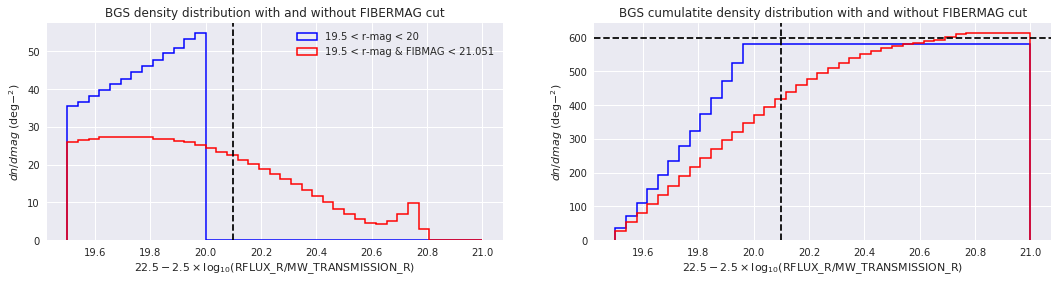

In [13]:
fig = plt.figure(figsize=(18, 4))

weights1 = np.zeros_like(rfibmag) + 1/A
bins1 = np.linspace(19.5, 21, 40)
mask1 = (bgs_sv) & (rmag > 19.5) & (rfibmag < 21.051)
mask2 = (bgs_sv) & (rmag > 19.5) & (rmag <= 20)

for i, cumu in zip([1,2], [False, True]):
    
    plt.subplot(1,2,i)

    c2 = plt.hist(rmag[mask2], bins=bins1, cumulative=cumu, histtype='step', align='mid', 
             weights=weights1[mask2], color='blue', linewidth=1.5, label=r'19.5 < r-mag < 20')

    c1 = plt.hist(rmag[mask1], bins=bins1, cumulative=cumu, histtype='step', align='mid', 
             weights=weights1[mask1], color='r', linewidth=1.5, label=r'19.5 < r-mag & FIBMAG < 21.051')

    if i == 1:
        plt.legend(loc='mid right')
        plt.title(r'BGS density distribution with and without FIBERMAG cut')
    if i == 2:
        plt.axhline(600, ls='--', c='k')
        plt.title(r'BGS cumulatite density distribution with and without FIBERMAG cut')
    plt.axvline(20.1, ls='--', c='k')

    plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'))
#plt.ylabel(r'$N/deg^2$')
    plt.ylabel(r'$dn/dmag$ (deg$-^2$)')

plt.show()

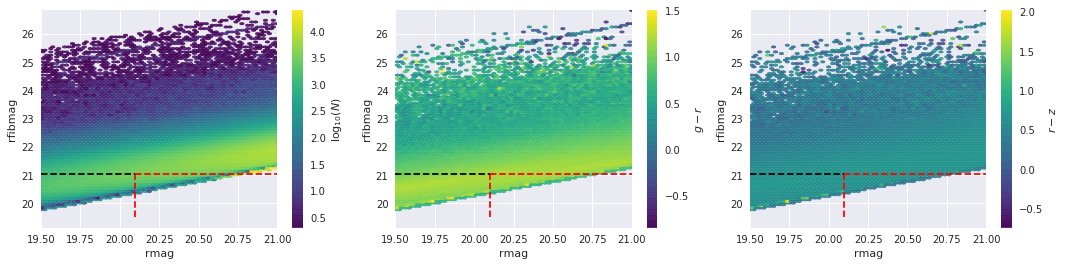

In [14]:
fig = plt.figure(figsize=(18, 4))
mask3 = (bgs_sv) & (rmag > 19.5)

plt.subplot(1, 3, 1)
pos = plt.hexbin(rmag[mask3], rfibmag[mask3], gridsize=(60,60), bins='log',
                 cmap='viridis', mincnt=1, alpha=0.8)

plt.plot(np.linspace(20.1, 21, 3), np.full(3, 21.0511), c='red', linestyle='--')
plt.plot(np.full(3, 20.1), np.linspace(19.5, 21.0511, 3), c='red', linestyle='--')
plt.plot(np.linspace(19.5, 20.1, 3), np.full(3, 21.0511), c='k', linestyle='--')
fig.colorbar(pos, label=r'$\log_{10}(N)$')
plt.xlabel(r'rmag')
plt.ylabel(r'rfibmag')

plt.subplot(1, 3, 2)
pos = plt.hexbin(rmag[mask3], rfibmag[mask3], C=gmag[mask3]-rmag[mask3], gridsize=(60,60),
                 cmap='viridis', mincnt=1, alpha=0.8)

plt.plot(np.linspace(20.1, 21, 3), np.full(3, 21.0511), c='red', linestyle='--')
plt.plot(np.full(3, 20.1), np.linspace(19.5, 21.0511, 3), c='red', linestyle='--')
plt.plot(np.linspace(19.5, 20.1, 3), np.full(3, 21.0511), c='k', linestyle='--')
fig.colorbar(pos, label=r'$g-r$')
plt.xlabel(r'rmag')
plt.ylabel(r'rfibmag')

plt.subplot(1, 3, 3)
pos = plt.hexbin(rmag[mask3], rfibmag[mask3], C=rmag[mask3]-zmag[mask3], gridsize=(60,60),
                 cmap='viridis', mincnt=1, alpha=0.8)

plt.plot(np.linspace(20.1, 21, 3), np.full(3, 21.0511), c='red', linestyle='--')
plt.plot(np.full(3, 20.1), np.linspace(19.5, 21.0511, 3), c='red', linestyle='--')
plt.plot(np.linspace(19.5, 20.1, 3), np.full(3, 21.0511), c='k', linestyle='--')
fig.colorbar(pos, label=r'$r-z$')
plt.xlabel(r'rmag')
plt.ylabel(r'rfibmag')

plt.show()

# Target densities

In [15]:
t, Acorr = GetPhotoStats(GeoCutsDict=GeoCut, GeoCutsDict_ran=GeoCut_ran, PhotCutsDict=PhotCut, CurrentMask=['QC_FM', 'QC_FI', 'QC_FF'], 
                 PrevMask=['BS', 'MS', 'GC', 'LG', 'allmask', 'nobs', 'SG', 'CC', 'FMC', 'QC_IVAR'], A=A, 
                      bits={'B':bright, 'F':faint, 'Fe':faint_ext, 'FMC':fmc})

t

Previous Cuts: (~BS & ~MS & ~GC & ~LG & ~allmask & ~nobs & SG & CC & FMC & QC_IVAR)
Current Cuts: (QC_FM&QC_FI&QC_FF)


PHOTOMETRY,$\eta_{B}$ [deg$^2$],$\eta_{F}$ [deg$^2$],$\eta_{Fe}$ [deg$^2$],$\eta_{fmc}$ [deg$^2$]
bytes20,float64,float64,float64,float64
~QC_FM,4.67,2.9,3.54,1.42
~QC_FI,1.06,0.32,0.26,0.04
~QC_FF,8.89,7.94,6.85,0.49
~(QC_FM&QC_FI&QC_FF),13.68,10.89,10.42,1.93
(QC_FM&QC_FI&QC_FF),884.19,749.61,791.23,210.87


In [19]:
print('Target density in lowq bit: %g 1/deg^2' %(np.sum(bgs_sv_bits['lowq'])/A))

Target density in lowq bit: 49.348 1/deg^2


In [16]:
Acorr

1349.9420148654085

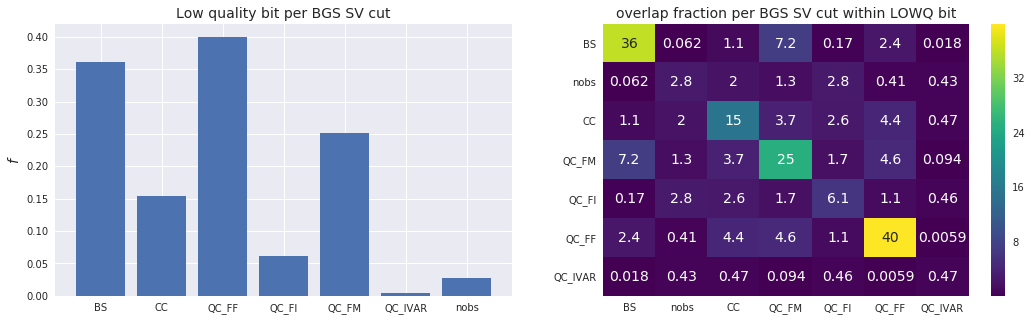

In [152]:
#get distributions of BGS SV quality control cuts in lowq bit...
import itertools
import pandas as pd

qcname = []
qcval = []

for key, val in zip(GeoCut.keys(), GeoCut.values()):
    if np.sum((val) & (bgs_sv_bits['lowq'])) < 1:
        continue
    qcname.append(key)
    qcval.append(np.sum((val) & (bgs_sv_bits['lowq']))/np.sum(bgs_sv_bits['lowq']))
    
for key, val in zip(PhotCut.keys(), PhotCut.values()):
    if np.sum((~val) & (bgs_sv_bits['lowq'])) < 1:
        continue
    qcname.append(key)
    qcval.append(np.sum((~val) & (bgs_sv_bits['lowq']))/np.sum(bgs_sv_bits['lowq']))

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.bar(qcname, qcval)
plt.title(r'Low quality bit per BGS SV cut', size=14)
plt.ylabel(r'$f$', size=14)

A = np.zeros( (len(qcname), len(qcname)) )

for row, col in itertools.product(range(len(qcname)), range(len(qcname))):
    
    if qcname[row] in GeoCut.keys():
        val1 = GeoCut[qcname[row]]
    else:
        val1 = ~PhotCut[qcname[row]]
        
    if qcname[col] in GeoCut.keys():
        val2 = GeoCut[qcname[col]]
    else:
        val2 = ~PhotCut[qcname[col]]
    #Matrix entries are the overlap fraction (in percentage) per BGS SV cut in lowq bit out of total in lowq bit
    A[row][col] = 100*np.sum((val1) & (val2) & (bgs_sv_bits['lowq']))/np.sum(bgs_sv_bits['lowq'])
    
plt.subplot(1,2,2)
data = pd.DataFrame(A, columns=qcname, index=qcname)
plt.title(r'overlap fraction per BGS SV cut within LOWQ bit', size=14)
ax = sns.heatmap(data, annot=True, annot_kws={"size": 14}, cmap="viridis")

plt.show()


# FIBMAG & FAINT_EXT overlap

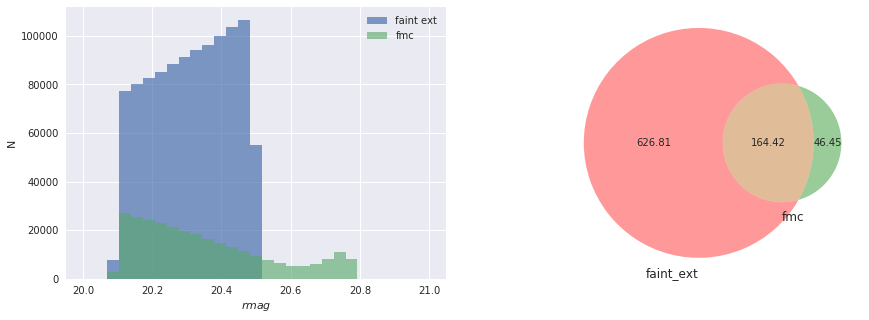

In [93]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
bins = np.linspace(20, 21, 30)
plt.hist(rmag[bgs_sv_bits['faint_ext']], bins=bins, alpha=0.7, label=r'faint ext')
plt.hist(rmag[bgs_sv_bits['fmc']], bins=bins, alpha=0.6, label=r'fmc')

plt.xlabel(r'$rmag$')
plt.ylabel(r'N')
plt.legend()

plt.subplot(1,2,2)
from matplotlib_venn import venn2

a = bgs_sv_bits['faint_ext'] 
b = bgs_sv_bits['fmc']
c = (a) & (b)

sf = 2
a1 = round((np.sum(a) - np.sum(c))/Acorr, sf)
b1 = round((np.sum(b) - np.sum(c))/Acorr, sf)
c1 = round(np.sum(c)/Acorr, sf)

venn2([a1, b1, c1], set_labels = ('faint_ext', 'fmc'))


# Overdensities around Bright Stars

In [158]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.gridspec as gridspec

def overdensity(cat, star, radii_1, nameMag, slitw, density=False, magbins=(8,14,4), radii_2=None, 
                grid=None, SR=[2, 240.], scaling=False, nbins=101, SR_scaling=4, logDenRat=[-3, 3], 
                    radii_bestfit=True, annulus=None, eqbined=False, filename=None):
    '''
    Get scatter and density plots of objects of cat1 around objects of cat2 within a search radius in arcsec.

    Inputs
    ------
    cat: (array) catalogue 1;
    star: (array) catalogue 2;
    nameMag: (string) label of magnitude in catalogue 2;
    slitw: (float, integer) slit widht;
    density: (boolean) True to get the density as function of distance (arcsec) within shells;
    magbins: (integers) format to separate the magnitude bins in cat2 (min, max, number bins);

    Output
    ------
    (distance (arcsec), density) if density=True
    '''
    # define the slit width for estimating the overdensity off diffraction spikes
    slit_width = slitw
    search_radius = SR[1]

    # Paramater for estimating the overdensities
    annulus_min = SR[0]
    annulus_max = SR[1]

    ra2 = star['RA']
    dec2 = star['DEC']
    
    ra1 = cat['RA']
    dec1 = cat['DEC']

    if density:

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2, dec2, ra1, dec1,
                                                 search_radius=search_radius)
        density = []
        shells = np.linspace(1, search_radius, search_radius)
        for i in range(len(shells)-1):

            ntot_annulus = np.sum((d2d>shells[i]) & (d2d<shells[i+1]))
            density_annulus = ntot_annulus/(np.pi*(shells[i+1]**2 - shells[i]**2))
            bincenter = (shells[i]+shells[i+1])/2

            density.append([bincenter, density_annulus])

        density = np.array(density).transpose()
        plt.figure(figsize=(12, 8))
        plt.semilogy(density[0], density[1])
        plt.xlabel(r'r(arcsec)')
        plt.ylabel(r'N/($\pi r^2$)')
        plt.grid()
        plt.show()

        return density


    if eqbined:
        mag_bins = np.linspace(magbins[0], magbins[1], magbins[2]+1)
        mag_bins_len = len(mag_bins)-1
    else:
        mag_bins = np.linspace(magbins[0], magbins[1], magbins[2])
        mag_bins_len = len(mag_bins)
    
    
    if grid is not None:
        rows, cols = grid[0], grid[1]
    else:
        rows, cols = len(mag_bins), 1
    figsize = (8*cols, 8*rows)
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.3, hspace=0.2)
    fig = plt.figure(num=1, figsize=figsize)
    ax = []
        
    for index in range(mag_bins_len):
        if eqbined:
            mask_star = (star[nameMag]>mag_bins[index]) & (star[nameMag]<mag_bins[index+1])
            title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index], nameMag, mag_bins[index+1], np.sum(mask_star))    
        else:
            if index==0:
                mask_star = (star[nameMag]<mag_bins[index])
                title = '{} < {:.2f}'.format(nameMag,mag_bins[0], np.sum(mask_star))
            else:
                mask_star = (star[nameMag]>mag_bins[index-1]) & (star[nameMag]<mag_bins[index])
                title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index-1], nameMag, mag_bins[index], np.sum(mask_star))

        print(title)

        if not scaling:
            #get the mask radii from the mean magnitude
            mag_mean = np.mean(star[nameMag][mask_star])
            print('mag_mean', mag_mean)
            mask_radius = circular_mask_radii_func([mag_mean], radii_1, bestfit=radii_bestfit)[0]
            if radii_2:
                mask_radius2 = circular_mask_radii_func([mag_mean], radii_2)[0]

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2[mask_star], dec2[mask_star], ra1, dec1,
                                                 search_radius=annulus_max)

        Nsources = len(ra2[mask_star])
        perc_sources = 100*len(ra2[mask_star])/len(ra2)
        
        #print('%d sources ~%g %% ' %(Nsources, perc_sources))
        
        mag_radii = circular_mask_radii_func(star[nameMag][mask_star][idx2], radii_1, bestfit=radii_bestfit)
        #print(len(d_ra), len(mag_radii))
        print('mag_radii MAX:',mag_radii.max(), 'mag_radii MIN:',mag_radii.min())
        print('mag MAX:',star[nameMag][mask_star][idx2].max(), 'mag MIN:',star[nameMag][mask_star][idx2].min())

        #markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])
        #axis = [-search_radius*1.05, search_radius*1.05, -search_radius*1.05, search_radius*1.05]
        #axScatter = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=title)
        
        row = (index // cols)
        col = index % cols
        ax.append(fig.add_subplot(gs[row, col]))
        
        if scaling:
            d2d_arcsec = d2d
            d_ra, d_dec, d2d = d_ra/mag_radii, d_dec/mag_radii, d2d_arcsec/mag_radii
            search_radius = SR_scaling #d2d.max() - d2d.max()*0.3
            #ntot_annulus = np.sum((d2d_arcsec>annulus_min) & (d2d<search_radius))
            ntot_annulus = np.sum(d2d<search_radius)
            #density_annulus = ntot_annulus/(np.pi*(search_radius**2 - d2d[d2d_arcsec > 2].min()**2))
            density_annulus = ntot_annulus/(np.pi*(search_radius**2))
            #print('ntot_annulus:', ntot_annulus, 'density_annulus:', density_annulus)
            print('d2d min=%2.3g, d2d max=%2.3g' %(d2d.min(), d2d.max()))
        else:
            d2d_arcsec = None
            ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
            density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        
        if annulus is not None:
            annMask = np.ones(len(cat), dtype='?')
            d_ra2 = np.zeros(len(cat))
            d_dec2 = np.zeros(len(cat))
            d_ra2[idx1] = d_ra
            d_dec2[idx1] = d_dec
            print(len(cat), len(d_ra2), len(d_dec2))
            #print(len(set(idx1)), len(set(idx2)))
            #print(idx1.max(), idx2.max())
            #angle_array = np.linspace(0, 2*np.pi, 240)
            annMask &= np.logical_and((d_ra2**2 + d_dec2**2) < annulus[1]**2, (d_ra2**2 + d_dec2**2) > annulus[0]**2)
            
            #annMask &= np.logical_and(d_dec < annulus[1] * np.cos(angle_array), d_dec > annulus[0] * np.cos(angle_array))
        
        bins, mesh_d2d, density_ratio = relative_density_plot(d_ra, d_dec, d2d, search_radius,
                        ref_density=density_annulus, return_res=True,
                            show=False, nbins=nbins, ax=ax[-1], d2d_arcsec=d2d_arcsec, annulus_min=annulus_min, logDenRat=logDenRat)
   
        if not scaling:
            angle_array = np.linspace(0, 2*np.pi, 240)
            x = mask_radius * np.sin(angle_array)
            y = mask_radius* np.cos(angle_array)
            ax[-1].plot(x, y, 'k', lw=4)
            
            ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.05, '%d sources ~%2.3g %% ' %(Nsources, perc_sources), fontsize=8,color='k')
            ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.11, '%d objects ~%2.3g %% ' %(ntot_annulus, 100*ntot_annulus/len(ra1)), fontsize=8,color='k')
            #ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.17, '$\eta$=%2.3g arcsec$^{-2}$' %(density_annulus), fontsize=8,color='k')

            ax[-1].set_xlabel(r'$\Delta$RA (arcsec)')
            ax[-1].set_ylabel(r'$\Delta$DEC (arcsec)')
        
            if radii_2:
                x2 = mask_radius2 * np.sin(angle_array)
                y2 = mask_radius2 * np.cos(angle_array)
                ax[-1].plot(x2, y2, 'k', lw=1.5, linestyle='--')
        else:
            angle_array = np.linspace(0, 2*np.pi, 100)
            x = 1 * np.sin(angle_array)
            y = 1 * np.cos(angle_array)
            ax[-1].plot(x, y, 'k', lw=4)
            
            ax[-1].text(-SR_scaling+0.1, SR_scaling-0.2, '%d sources ~%2.3g %% ' %(Nsources, perc_sources), fontsize=10,color='k')
            ax[-1].text(-SR_scaling+0.1, -SR_scaling+0.1, '%d objects ~%2.3g %% ' %(ntot_annulus, 100*ntot_annulus/len(ra1)), fontsize=10,color='k')
            #ax[-1].text(-SR_scaling+0.1, SR_scaling-0.9, '$\eta$=%2.3g deg$^{-2}$' %(density_annulus), fontsize=8,color='k')

            ax[-1].set_xlabel(r'$\Delta$RA/radii$_{i}$')
            ax[-1].set_ylabel(r'$\Delta$DEC/radii$_{i}$')
            
        ax[-1].set_title(title)
        if annulus is not None:
            for i in annulus:
                x = i * np.sin(angle_array)
                y = i * np.cos(angle_array)
                ax[-1].plot(x, y, 'yellow', lw=3, ls='-')
                
    if filename is not None:
            fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0)
    
    if annulus is not None:
        return d_ra2, d_dec2, annMask
        
        
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs:
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs:
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec);
    '''

    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))

    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

def relative_density_plot(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, return_res=False, 
                          show=True, ax=plt, d2d_arcsec=None, annulus_min=2, logDenRat=[-3,3]):

    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    if d2d_arcsec is not None:
        mask = (d2d_arcsec>annulus_min) #to avoid self match with stars
    else:
        mask = (d2d>annulus_min) #to avoid self match with stars
    #taking the 2d histogram and divide by the area of each bin to get the density
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    #ignoring data outside the circle with radius='search radius'
    #print('Nbins:',len(bins), 'binArea:', bin_spacing**2, 'Nobjects:', len(d_ra[mask]))
    #pix_density = len(d_ra[mask])/((len(bins)**2)*(bin_spacing**2))
    #print('tot_density_pix:', pix_density)
    
    #mean density at search radius
    if search_radius < 10:
        meanmask = np.logical_and(mesh_d2d <= search_radius, mesh_d2d > 1.2)
    else:
        meanmask = np.logical_and(mesh_d2d <= search_radius, mesh_d2d > 100.)
    ref_density = np.mean(density[meanmask])
    
    #density profile
    dist = np.linspace(0., search_radius, nbins)
    dist2 = np.linspace(0.008, search_radius, nbins/2.)
    dist_spacing = dist[1] - dist[0]
    dist_spacing2 = dist2[1] - dist2[0]
    dpx, dpy, dpx2, dpy2 = [], [], [], []
    for i, j in enumerate(dist):
        #for the cumulative radia profile
        dmask = mesh_d2d <= j
        drcumu = np.log2(np.mean(density[dmask]/ref_density))
        if drcumu is np.nan:
            dpy.append(-1)
        else:
            dpy.append(drcumu)
        dpx.append(j)
    for i, j in enumerate(dist2[:-1]):
        #for the no cumulative radia profile
        dmask2 = np.logical_and(mesh_d2d < dist2[i+1], mesh_d2d >= dist2[i])
        #drnocumu = np.log2(np.mean(density[dmask2]/ref_density))
        drnocumu = np.mean(density[dmask2]/ref_density) -1.
        if drnocumu is np.nan:
            dpy2.append(-1)
        else:
            dpy2.append(drnocumu)
        dpx2.append(dist2[i] + dist_spacing2/2.)
    
    if search_radius < 10:
        dpy = np.array(dpy)
        dpy2 = np.array(dpy2)
    else:
        dpy = np.array(dpy)*100
        dpy2 = np.array(dpy2)*100
    
    print('density cumu (min, max): (%2.3g, %2.3g)' %(np.array(dpy).min(), np.array(dpy).max()))
    print('density non-cumu (min, max): (%2.3g, %2.3g)' %(np.array(dpy2).min(), np.array(dpy2).max()))
    
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    #density_ratio = density/ref_density
    density_ratio = np.log2(density/ref_density)
    
    idxinf = np.where(np.isinf(density_ratio))
    #print('inf values:',density_ratio[idxinf])
    print('%d of inf in density ratio out of a total of %d' %(len(density_ratio[idxinf]), len(density_ratio[~np.isnan(density_ratio)])))
    density_ratio[idxinf] = logDenRat[0]
    #print('inf values AFTER:',density_ratio[idxinf])
    
    den_rat = density_ratio[~np.isnan(density_ratio)]
    denmin = den_rat.min()
    denmax = den_rat.max()
    print('Minimum density ratio = %g, Maximum density ratio = %g' %(denmin, denmax))
    print('----------------')
    fig = plt.figure(1)
    #img = ax.imshow(density_ratio.transpose()-1, origin='lower', aspect='equal',
    img = ax.imshow(density_ratio.transpose(), origin='lower', aspect='equal',
               cmap='seismic', extent=bins.max()*np.array([-1, 1, -1, 1]), vmin=logDenRat[0], vmax=logDenRat[1])
    #ax.colorbar(fraction=0.046, pad=0.04)
    fig.colorbar(img, fraction=0.046, pad=0.04, label=r'$\log_{2}(\eta_{pix}/\eta_{tot})$')
    #ax.plot(np.array(dpx), dpy, lw=2.5, color='green')
    ax.plot(np.array(dpx2), dpy2, lw=2.5, color='red')
    
    ax.set_ylim(-search_radius, search_radius)
    if show:
        ax.show()

    if return_res:
        return bins, mesh_d2d, density_ratio

### Loading Tycho2 catalogue as Star catalogue

In [10]:
from legacypipe.gaiacat import GaiaCatalog
import os
import astrometry

ModuleNotFoundError: No module named 'astrometry'

In [ ]:
gaia = GaiaCatalog().get_catalog_in_wcs(targetwcs)

In [9]:
os.environ['GAIA_CAT_DIR'] = '/global/project/projectdirs/cosmo/data/gaia/dr2/healpix'
gaia = GaiaCatalog().get_catalog_radec_box(160, 230, -2, 18)

ModuleNotFoundError: No module named 'astrometry'

In [223]:
!ls /global/project/projectdirs/cosmo/data/gaia/dr2/

csv  fits  healpix


In [211]:
gaia = fitsio.read('/global/project/projectdirs/cosmo/data/gaia/dr2/healpix/healpix-00002.fits')

In [219]:
nside, pixdict = check_hp_target_dir('/global/project/projectdirs/cosmo/data/gaia/dr2/healpix')

OSError: extension not found: targets (case insensitive)

In [154]:
#Loading Tycho2 catalogue
path = '/global/homes/q/qmxp55/DESI/matches/'
tycho_ = fitsio.read(path+'tycho2.fits')
#tycho_ = fitsio.read('tycho2.fits') #for tardispc
#cutting out to the same footprint as DECaLS catalogue plus 0.5 deg in the edges
delta = 0.5
tycho = cut(main_patch[0] - delta, main_patch[1] + delta, main_patch[2] - delta, main_patch[3] + delta, tycho_)

In [155]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])

In [193]:
bgs_sv_notBS = cuts(np.concatenate((list(PhotCut.keys()), ['MS', 'GC', 'LG', 'allmask', 'nobs'])))
bgs_sv_bits_notBS = {'bright':(bgs_sv_notBS & bright), 
                     'faint':(bgs_sv_notBS & faint), 
                     'faint_ext':(bgs_sv_notBS & faint_ext), 
                     'fmc':(bgs_sv_notBS & fmc), 
                     #'lowq':(cuts('lowq') & (rmag < 20.1))
              }

6.00 < MAG_VT < 13.00
1077925 nearby objects ~ 89.6293 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.0203, d2d max=18.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-0.722, 2.6)
32 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 3.6002
----------------


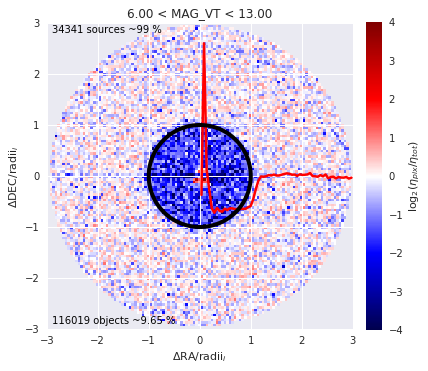

6.00 < MAG_VT < 13.00
918153 nearby objects ~ 89.8382 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.0691, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0982)
31 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 2.81585
----------------


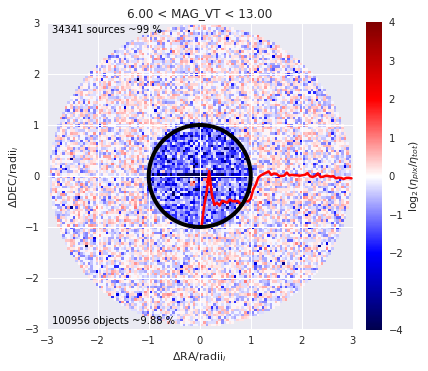

6.00 < MAG_VT < 13.00
970238 nearby objects ~ 89.8353 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.0686, d2d max=18.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0619)
32 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 2.5936
----------------


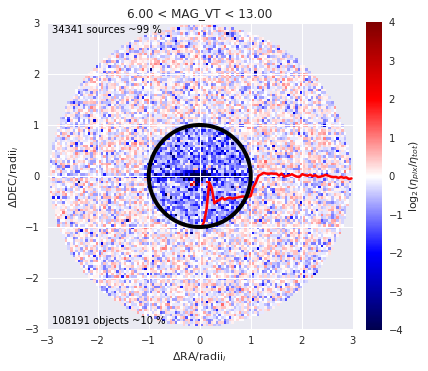

6.00 < MAG_VT < 13.00
292883 nearby objects ~ 94.7023 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.064, d2d max=18.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 4.23)
520 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 5.0943
----------------


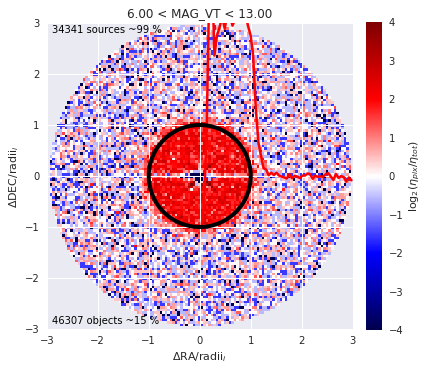

In [196]:
#plt.figure(figsize=(18, 6))
for key, val in zip(bgs_sv_bits_notBS.keys(), bgs_sv_bits_notBS.values()):

    #plt.subplot(1, 2, num)
    #print(num)
    #plt.title(key)
    plt.figure(figsize=(6, 6))
    _ = overdensity(df[val], tycho, Dustin_MS_radii, 'MAG_VT', 35, density=False, 
                magbins=(6,13,1), radii_2=None, grid=[1,1], SR=[1., 400.], scaling=True, nbins=121, 
                        SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                            filename='%s/%s/2Dstack_tycho_rescaling_sr300' %(dir_name, subdir))
    plt.show()
    

6.00 < MAG_VT < 13.00
1063378 nearby objects ~ 89.0893 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.0203, d2d max=18.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0588)
1181 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 1.23843
----------------


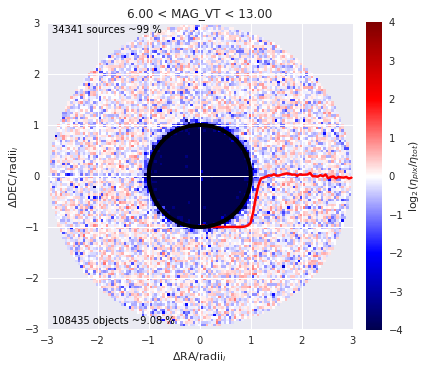

6.00 < MAG_VT < 13.00
901965 nearby objects ~ 89.1333 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.73, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0799)
1216 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 1.22886
----------------


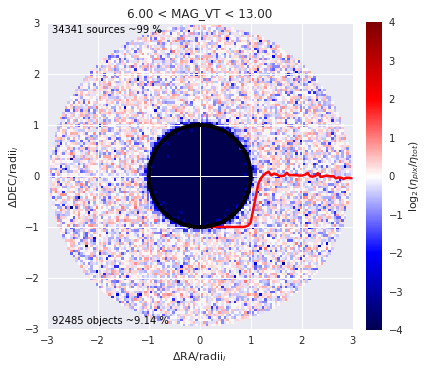

6.00 < MAG_VT < 13.00
951216 nearby objects ~ 89.0557 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.616, d2d max=18.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0459)
1206 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 1.20731
----------------


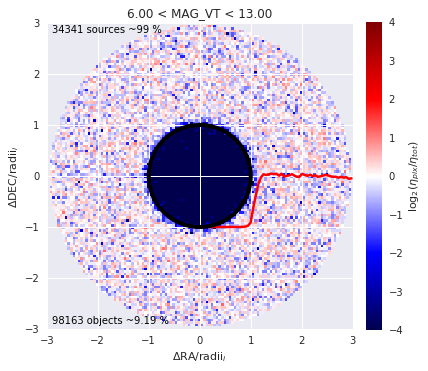

6.00 < MAG_VT < 13.00
253600 nearby objects ~ 89.0865 %
mag_radii MAX: 180.541219898 mag_radii MIN: 21.363907222
mag MAX: 12.999 mag MIN: 6.013
d2d min=0.616, d2d max=18.6
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1, 0.0827)
2080 of inf in density ratio out of a total of 10960
Minimum density ratio = -4, Maximum density ratio = 2.06726
----------------


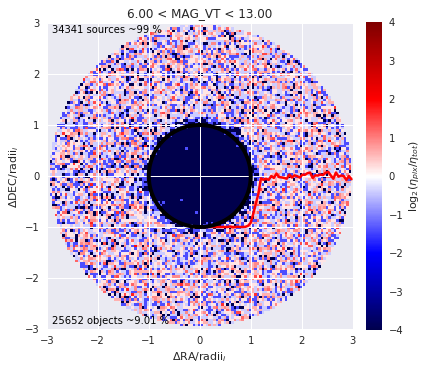

In [200]:
for key, val in zip(list(bgs_sv_bits.keys())[:-1], list(bgs_sv_bits.values())[:-1]):

    plt.figure(figsize=(6, 6))
    _ = overdensity(df[val], tycho, Dustin_MS_radii, 'MAG_VT', 35, density=False, 
                magbins=(6,13,1), radii_2=None, grid=[1,1], SR=[1., 400.], scaling=True, nbins=121, 
                        SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                            filename='%s/%s/2Dstack_tycho_rescaling_sr300' %(dir_name, subdir))
    plt.show()
    